In [1]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers

1. create PU and collocation points 
2. create trees for PU and collocation points 
3. for each PU point:
    1. find collocation points in range
    2. calculate the distance tensor 
    3. 

1 Create a tree of collocation points 
2 create a tree of PU points 

In [30]:
@variables ϵ r x₁ x₂ ;
#r = sqrt(x₁^2 + x₂^2)
ϕ = exp(-r^2*ϵ^2)
#ϕ = (1-r*ϵ)^8 * (32*(r*ϵ)^3 + 25* (r*ϵ)^2 + 8*r*ϵ + 1)
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ = simplify(ϕ,expand = true)
display(ϕ)  
#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₁/r),expand = true)
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₂/r),expand = true)
Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))

#Φ_div = substitute.([ϕ 0.0 ; 0.0 ϕ],r=>sqrt(x₁^2 + x₂^2))
λ1(x) = x[1]
λ2(x) = x[2]
phi = eval(build_function(substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)), [x₁, x₂], ϵ))
#simplified = substitute(simplify(∂₁(∂₁(ϕ))), r=>sqrt(x₁^2 + x₂^2)) 
#simplified = eval(build_function(simplified, [x₁, x₂], ϵ))

#singular = substitute(∂₁(∂₁(ϕ)), r=>sqrt(x₁^2 + x₂^2)) 
#singular = eval(build_function(singular, [x₁, x₂], ϵ))
display(Φ_div)
#phi([0,0],10)

exp(-(r^2)*(ϵ^2))

2×2 Matrix{Num}:
       2(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - 4(x₂^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  4x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 4x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                             2(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - 4(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

In [31]:
K = construct_kernel_array(Φ_div,[λ1,λ2],[λ1,λ2])
display(K)
K = compile_kernel_array(K)
K[1,1]([0.0,0.0],1)

2×2 Matrix{Num}:
       2(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - 4(x₂^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  4x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 4x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                             2(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - 4(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

2.0

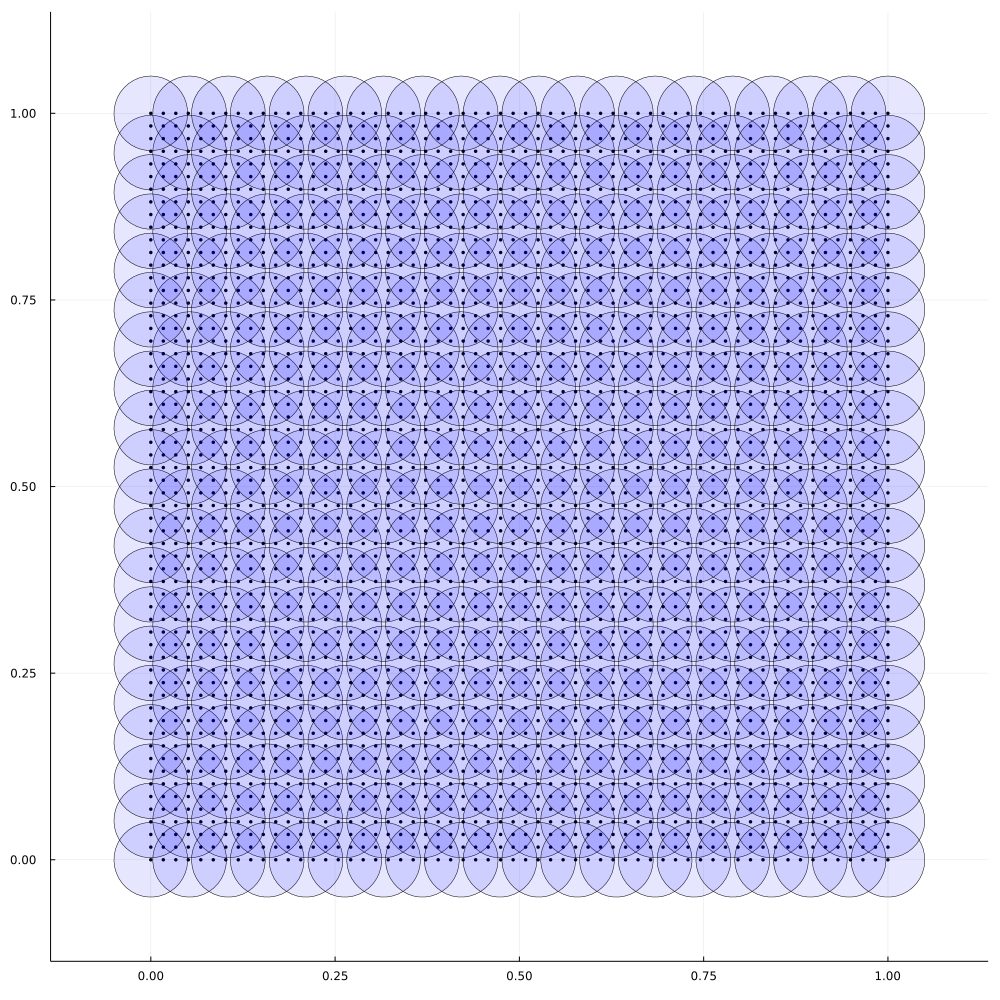

In [94]:
# create points
function circle(x,y,r)
    phi = LinRange(0,2*π,40)
    return x .+ r*sin.(phi), y .+ r*cos.(phi)
end
N_coll = 60
N_pu = Int(N_coll/3)
r_pu = 1/N_pu
Coll_points = hcat(generate_2D_equally_spaced_points(N_coll)...)
PU_points = hcat(generate_2D_equally_spaced_points(N_pu)...)
Test_points = hcat(generate_2D_equally_spaced_points(53)...)
Test_points = generate_2D_Halton_points(3000)
scatter(Coll_points[1,:],Coll_points[2,:],markersize = 2,markercolor = :black,size=(1000,1000),lims=[-0.1,1.1])
#scatter!(Test_points[1,:],Test_points[2,:],markersize = 3,markercolor = :green,linecolor=:green)
for i in 1:size(PU_points)[2]
    x = PU_points[1,i]
    y = PU_points[2,i]
    plot!(circle(x,y,r_pu),seriestype = [:shape,],linecolor=:black,legend=false,c =:blue,fillalpha = 0.1,linewidth= 0.5)
end
#scatter!(PU_points[1,:],PU_points[2,:],markercolor = :blue,markeralpha = 0.1,markersize = Int(r_pu*600),markerstrokealpha = 0)
plot!()

In [95]:
# function that builds the interpolation matrix 
function PU_interpolation_matrix(Points1,Points2,PU_Points,f,ϵ,r_pu)
    #f in the function that acts on the distance tensor,ϵ is the shape parameter, r_pu is the partition radius
    # compute all the trees 
    PU_tree = KDTree(PU_Points,Euclidean(),leafsize = 3)
    Collocation_tree = KDTree(Points2,Euclidean(),leafsize = 3)
    Test_tree  = KDTree(Points1,Euclidean(),leafsize = 3)
    M = zeros(size(Points1)[2],size(Points2)[2]) # later be replaced with sparse matrix
    scaling_vector= zeros(size(Points1)[2])
    for i in 1:size(PU_Points)[2]
        coll_indx = inrange(Collocation_tree, PU_Points[:,i], r_pu, true)
        tst_indx = inrange(Test_tree, PU_Points[:,i], r_pu, true)
        Local_distance_tensor = point_difference_tensor(Points1[:,tst_indx],Points2[:,coll_indx])
        Local_interpolation_matrix = apply(f, Local_distance_tensor,ϵ)
        M[tst_indx,coll_indx] .+= Local_interpolation_matrix
        scaling_vector[tst_indx] .+= 1
        #println(cond(Local_interpolation_matrix))
    end
    #println(scaling_vector)
    return M .* (1 ./scaling_vector)
end
param = 7.0
M11 = PU_interpolation_matrix(Coll_points,Coll_points,PU_points,K[1,1],param,r_pu)
M12 = PU_interpolation_matrix(Coll_points,Coll_points,PU_points,K[1,2],param,r_pu)
M21 = PU_interpolation_matrix(Coll_points,Coll_points,PU_points,K[2,1],param,r_pu)
M22 = PU_interpolation_matrix(Coll_points,Coll_points,PU_points,K[2,2],param,r_pu)
M = vcat(hcat(M11,M12),hcat(M21,M22))
E11 = PU_interpolation_matrix(Test_points,Coll_points,PU_points,K[1,1],param,r_pu)
E12 = PU_interpolation_matrix(Test_points,Coll_points,PU_points,K[1,2],param,r_pu)
E21 = PU_interpolation_matrix(Test_points,Coll_points,PU_points,K[2,1],param,r_pu)
E22 = PU_interpolation_matrix(Test_points,Coll_points,PU_points,K[2,2],param,r_pu)

E = vcat(hcat(E11,E12),hcat(E21,E22))
#M
#heatmap(M)

6000×7200 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [96]:
length(sparse(M).nzval)/(size(M)[1]^2)*100

1.2903395061728395

In [98]:
#test problem 
function true_v1(x,y)
    return 20*x*y^3
end
function true_v2(x,y)
    return 5*x^4 - 5*y^4
end
b = vcat(true_v1.(Coll_points[1,:],Coll_points[2,:]),true_v2.(Coll_points[1,:],Coll_points[2,:]))
reference_v = vcat(true_v1.(Test_points[1,:],Test_points[2,:]),true_v2.(Test_points[1,:],Test_points[2,:]))

c =M\b
#c = gmres(sparse(M),b)

7200-element Vector{Float64}:
  -0.0009659144170447694
   0.00738077974655669
   0.02041803508375699
   0.00822534560124777
  -0.009330410247350932
   0.002460514474192804
   0.0016843092157170592
   0.024258924576344102
  -0.04759979489592583
  -0.025744634081810738
   0.016942591073899095
  -0.012926213126912145
   0.10391692524562743
   ⋮
  -0.5769417432291752
  -1.709145727727169
   2.624468730187233
  -1.7149983808497902
  -0.3191911878098178
  -7.786153324367553
  30.446405216784143
 -22.881603328064404
  -3.442163377237532
   1.5399549349362671
   2.4543513829241923
  -4.134322475721095

0.011798854933343315
0.46669420096658243


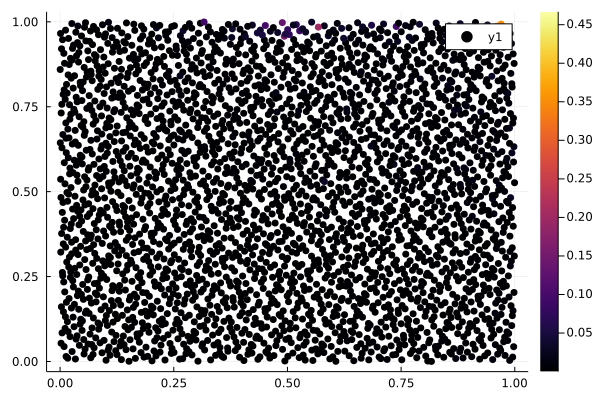

In [99]:
error = abs.(E*c - reference_v)
println(sqrt(sum(error .^2)/length(error)))
#surface((E*c)[1:Int(length(error)/2)],Test_points[1,:],Test_points[2,:])

#length(Test_points[1,:])
println(maximum(abs.(error)))
scatter(Test_points[1,:], Test_points[2,:], zcolor=error[1:Int(length(error)/2)],markerstrokewidth = 0,markerstrokestyle  = :rect )